In [29]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
import os
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import *
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV  


In [30]:
# Cargar archivos del preprocesamiento y crear conjunto de validación
# Leemos X e y procesados (csv generados en preprocesamiento)
X_train_processed = pd.read_csv('..\preprocessing\X_train_proc.csv')
X_test_processed = pd.read_csv('..\preprocessing\X_test_proc.csv')
# y vienen como DataFrame de una columna; convertir a Series
y_train_processed = pd.read_csv('..\preprocessing\y_train_raw.csv').iloc[:, 0]
y_test = pd.read_csv('..\preprocessing\y_test_raw.csv').iloc[:, 0]

# Crear conjunto de validación a partir de X_train_processed (stratificado)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_processed, y_train_processed,
    test_size=0.25,
    stratify=y_train_processed,
    random_state=42
)

# Para mantener compatibilidad con el resto del notebook, renombramos X_test como X_test_processed (ya cargado)
X_test = X_test_processed


In [31]:
print("X_train (procesado) shape:", X_train.shape)
print("X_val (procesado) shape:", X_val.shape)
print("y_train (serie) shape:", y_train.shape)
print("y_val (serie) shape:", y_val.shape)
print("X_test (procesado) shape:", X_test.shape)
print("y_test (serie) shape:", y_test.shape)


X_train (procesado) shape: (29304, 14)
X_val (procesado) shape: (9769, 14)
y_train (serie) shape: (29304,)
y_val (serie) shape: (9769,)
X_test (procesado) shape: (9769, 14)
y_test (serie) shape: (9769,)


In [32]:
print("y_train tamaño:", y_train.shape)
print("Valores únicos en y_train:", y_train.nunique())

y_train tamaño: (29304,)
Valores únicos en y_train: 2


In [33]:


# Definir modelos base
lgbm_model = LGBMClassifier(random_state=42)
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf_model  = RandomForestClassifier(random_state=42)

In [34]:
# ...existing code...
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Definir modelos base (mismos nombres que en el notebook)
models = [
    ('LightGBM', lgbm_model),
    ('XGBoost', xgb_model),
    ('RandomForest', rf_model)
]

print("\nEntrenando modelos base (sin tuning) sobre X_train...")
for name, model in models:
    print(f" - Entrenando {name}...")
    model.fit(X_train, y_train)
print("✓ Modelos base entrenados\n")

# Datasets a evaluar
datasets = [('Train', X_train, y_train)]
if 'X_val' in globals() and 'y_val' in globals():
    datasets.append(('VALIDACIÓN', X_val, y_val))

# Evaluación: construir tablas por dataset
for ds_name, X_ds, y_ds in datasets:
    rows = []
    for name, model in models:
        y_pred = model.predict(X_ds)
        y_proba = model.predict_proba(X_ds)[:, 1] if hasattr(model, "predict_proba") else None

        acc = accuracy_score(y_ds, y_pred)
        prec = precision_score(y_ds, y_pred, zero_division=0)
        rec = recall_score(y_ds, y_pred, zero_division=0)
        f1 = f1_score(y_ds, y_pred, zero_division=0)

        if y_proba is not None:
            try:
                roc = roc_auc_score(y_ds, y_proba)
            except ValueError:
                roc = np.nan
        else:
            roc = np.nan

        rows.append({
            'Model': name,
            'Accuracy': acc,
            'Precision': prec,
            'Recall': rec,
            'F1': f1,
            'ROC_AUC': roc
        })

    df = pd.DataFrame(rows).set_index('Model')
    print("=" * 60)
    print(f"EVALUACIÓN EN {ds_name}")
    print("=" * 60)
    display(df.round(4))  # en notebook mostrará tabla; si se ejecuta como script, usa print(df.round(4)))
    print("\n")


Entrenando modelos base (sin tuning) sobre X_train...
 - Entrenando LightGBM...
[LightGBM] [Info] Number of positive: 7048, number of negative: 22256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 29304, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240513 -> initscore=-1.149868
[LightGBM] [Info] Start training from score -1.149868
 - Entrenando XGBoost...


c:\Users\isma_\miniconda3\envs\prediccion\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:13:44] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


 - Entrenando RandomForest...
✓ Modelos base entrenados

EVALUACIÓN EN Train


,Accuracy,Precision,Recall,F1,ROC_AUC
Model,,,,,
LightGBM,0.8688,0.7686,0.6503,0.7045,0.9291
XGBoost,0.8962,0.8219,0.7256,0.7708,0.9539
RandomForest,0.9999,0.9999,0.9999,0.9999,1.0000




EVALUACIÓN EN VALIDACIÓN


,Accuracy,Precision,Recall,F1,ROC_AUC
Model,,,,,
LightGBM,0.8475,0.7056,0.6275,0.6643,0.9045
XGBoost,0.8398,0.6840,0.6203,0.6506,0.8983
RandomForest,0.8392,0.6858,0.6113,0.6464,0.8918


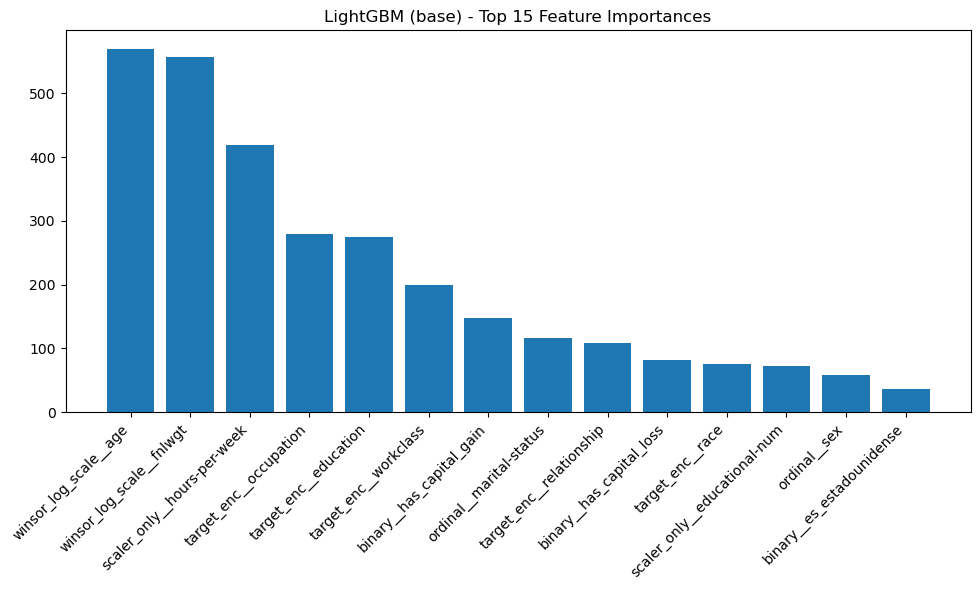

In [35]:
# Feature importance LightGBM (modelo base)
import matplotlib.pyplot as plt

feature_names = X_train.columns
if hasattr(lgbm_model, 'feature_importances_'):
    importances = lgbm_model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]  # Top 15

    plt.figure(figsize=(10, 6))
    plt.title("LightGBM (base) - Top 15 Feature Importances")
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

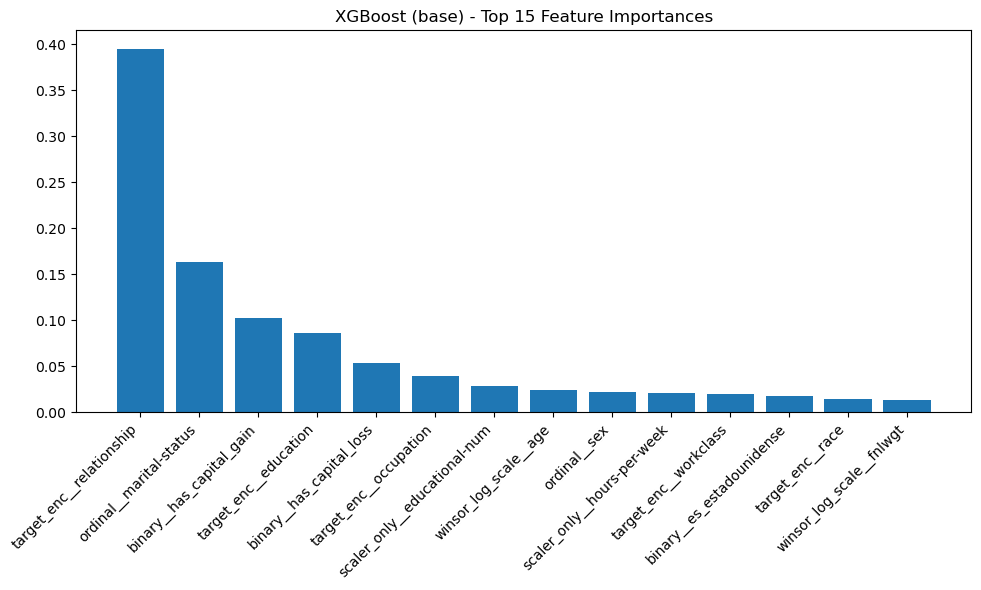

In [36]:
# Feature importance XGBoost (modelo base)
feature_names = X_train.columns
if hasattr(xgb_model, 'feature_importances_'):
    importances = xgb_model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]  # Top 15

    plt.figure(figsize=(10, 6))
    plt.title("XGBoost (base) - Top 15 Feature Importances")
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


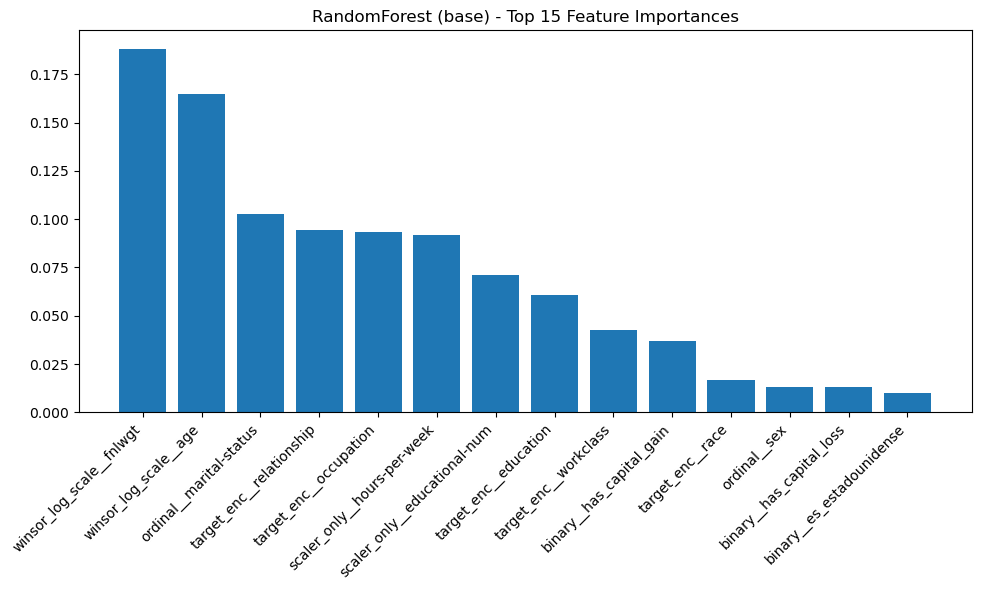

In [37]:
# Feature importance RandomForest (modelo base)
feature_names = X_train.columns
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]  # Top 15

    plt.figure(figsize=(10, 6))
    plt.title("RandomForest (base) - Top 15 Feature Importances")
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


In [38]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = 'f1'  # métrica principal para optimizar



In [39]:
# Definir grids
lgbm_param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 63],
    'max_depth': [-1, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.5]
}

rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}



In [40]:
print("Iniciando GridSearch para LightGBM...")
lgbm_gs = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=lgbm_param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2
)
lgbm_gs.fit(X_train, y_train)
lgbm_best = lgbm_gs.best_estimator_
print("LightGBM best f1:", lgbm_gs.best_score_)
print("LightGBM best params:", lgbm_gs.best_params_)


Iniciando GridSearch para LightGBM...
Fitting 3 folds for each of 216 candidates, totalling 648 fits
[LightGBM] [Info] Number of positive: 7048, number of negative: 22256
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 484
[LightGBM] [Info] Number of data points in the train set: 29304, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.240513 -> initscore=-1.149868
[LightGBM] [Info] Start training from score -1.149868
LightGBM best f1: 0.6594329837560194
LightGBM best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 31, 'subsample': 0.8}


In [41]:
print("\nIniciando GridSearch para XGBoost...")
xgb_gs = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=xgb_param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2
)
xgb_gs.fit(X_train, y_train)
xgb_best = xgb_gs.best_estimator_
print("XGBoost best f1:", xgb_gs.best_score_)
print("XGBoost best params:", xgb_gs.best_params_)


Iniciando GridSearch para XGBoost...
Fitting 3 folds for each of 216 candidates, totalling 648 fits


c:\Users\isma_\miniconda3\envs\prediccion\Lib\site-packages\xgboost\training.py:183: UserWarning: [12:24:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost best f1: 0.6635652877417081
XGBoost best params: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}


In [42]:
print("\nIniciando GridSearch para RandomForest...")
rf_gs = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=2
)
rf_gs.fit(X_train, y_train)
rf_best = rf_gs.best_estimator_
print("RandomForest best f1:", rf_gs.best_score_)
print("RandomForest best params:", rf_gs.best_params_)


Iniciando GridSearch para RandomForest...
Fitting 3 folds for each of 72 candidates, totalling 216 fits
RandomForest best f1: 0.6506109158848187
RandomForest best params: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [43]:
# Guardar mejores parámetros para reutilizar en el Voting/pipeline
lgbm_params = lgbm_gs.best_params_
xgb_params = xgb_gs.best_params_
rf_params = rf_gs.best_params_

In [44]:
# Evaluar los modelos finales en el conjunto de validación (sin usar eval_model)
print("\nEvaluación de los modelos optimizados en X_val:")
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

for name, model in [('LightGBM', lgbm_best), ('XGBoost', xgb_best), ('RandomForest', rf_best)]:
    print("\n" + "=" * 60)
    print(f"EVALUACIÓN (VALIDACIÓN - optimizado): {name}")
    print("=" * 60)

    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_val, y_pred)
    prec = precision_score(y_val, y_pred, zero_division=0)
    rec = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)

    if y_proba is not None:
        try:
            roc = roc_auc_score(y_val, y_proba)
            roc_str = f"{roc:.4f}"
        except ValueError:
            roc_str = "N/A"
    else:
        roc_str = "N/A"

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC AUC  : {roc_str}")



Evaluación de los modelos optimizados en X_val:

EVALUACIÓN (VALIDACIÓN - optimizado): LightGBM
Accuracy : 0.8471
Precision: 0.7054
Recall   : 0.6249
F1-score : 0.6628
ROC AUC  : 0.9052

EVALUACIÓN (VALIDACIÓN - optimizado): XGBoost
Accuracy : 0.8471
Precision: 0.7062
Recall   : 0.6232
F1-score : 0.6621
ROC AUC  : 0.9048

EVALUACIÓN (VALIDACIÓN - optimizado): RandomForest
Accuracy : 0.8457
Precision: 0.7111
Recall   : 0.6037
F1-score : 0.6530
ROC AUC  : 0.9024


# Persistencia

In [45]:
# Guardar modelos optimizados

os.makedirs("../models", exist_ok=True)
joblib.dump(lgbm_best, '../models/LightGBM_gridsearch.pkl')
joblib.dump(xgb_best,  '../models/XGBoost_gridsearch.pkl')
joblib.dump(rf_best,   '../models/RandomForest_gridsearch.pkl')
print("\n✓ Modelos optimizados guardados en ../models/")


✓ Modelos optimizados guardados en ../models/


In [46]:
# Crear VotingClassifier usando los modelos optimizados (lgbm_best, xgb_best, rf_best)
# De esta forma el voting_clf contiene los estimadores ya afinados
voting_clf = VotingClassifier(
    estimators=[
        ('lgbm', lgbm_best),
        ('xgb',  xgb_best),
        ('rf',   rf_best)
    ],
    voting='soft',
    n_jobs=-1
)

In [47]:
# Entrenar VotingClassifier en datos procesados
voting_clf.fit(X_train_processed, y_train_processed)

# Guardar VotingClassifier
joblib.dump(voting_clf, '../models/VotingClassifier.pkl')
print("VotingClassifier guardado")

VotingClassifier guardado


In [48]:
#importar el preprocesador
preprocessor = joblib.load("..\preprocessing\preprocesador.pkl")

In [49]:
# Crear pipeline completo: preprocesador + voting classifier
# Usamos el voting_clf ya construido (con los modelos optimizados) para aplicar el modelo a datos crudos
pipeline_voting = Pipeline(steps=[
    ("preprocesador", preprocessor),
    ("voting_clf", voting_clf)
])

In [50]:
# Cargar datos crudos de entrenamiento
X_train_raw = pd.read_csv("../preprocessing/X_train_raw.csv")
y_train_raw = pd.read_csv("../preprocessing/y_train_raw.csv").iloc[:, 0]

In [51]:
if 'X_train_raw' not in globals():
    X_train_raw = pd.read_csv("../preprocessing/X_train_raw.csv")
if 'y_train_raw' not in globals():
    y_train_raw = pd.read_csv("../preprocessing/y_train_raw.csv").iloc[:, 0]

# Preferir y_test ya cargado si existe; si no, cargar raw
if 'X_test_raw' not in globals():
    # puede que solo exista X_test_processed; intentar cargar raw
    try:
        X_test_raw = pd.read_csv("../preprocessing/X_test_raw.csv")
    except Exception:
        X_test_raw = X_test  # fallback si solo existe procesado

if 'y_test_raw' not in globals():
    if 'y_test' in globals():
        y_test_raw = y_test
    else:
        y_test_raw = pd.read_csv("../preprocessing/y_test_raw.csv").iloc[:, 0]



In [52]:
# Particionar X_train_raw/y_train_raw en train (75%) y validación (25%) estratificado
X_train_raw_train, X_val_raw, y_train_raw_train, y_val_raw = train_test_split(
    X_train_raw,
    y_train_raw,
    test_size=0.25,
    stratify=y_train_raw,
    random_state=42
)

# Comprobar tamaños para evitar data leakage
print("Tamaños después del split (raw):")
print(f"  X_train_raw_train: {X_train_raw_train.shape}, y: {y_train_raw_train.shape}")
print(f"  X_val_raw         : {X_val_raw.shape}, y: {y_val_raw.shape}")
print(f"  X_test_raw        : {X_test_raw.shape}, y: {y_test_raw.shape}")

# (Opcional) mostrar también shapes de y_train/y_test ya existentes para confirmar
if 'y_train' in globals():
    print(f"\nNota: existe 'y_train' con shape: {y_train.shape}")
if 'y_test' in globals():
    print(f"Nota: existe 'y_test' con shape: {y_test.shape}")


Tamaños después del split (raw):
  X_train_raw_train: (29304, 14), y: (29304,)
  X_val_raw         : (9769, 14), y: (9769,)
  X_test_raw        : (9769, 14), y: (9769,)

Nota: existe 'y_train' con shape: (29304,)
Nota: existe 'y_test' con shape: (9769,)


In [53]:
# Entrenar pipeline completo (preprocesador + voting) solo con el subconjunto de entrenamiento crudo
print("\nEntrenando pipeline completo (preprocesador + voting) sobre el subconjunto de entrenamiento crudo")
pipeline_voting.fit(X_train_raw_train, y_train_raw_train)
print("Pipeline entrenado")




Entrenando pipeline completo (preprocesador + voting) sobre el subconjunto de entrenamiento crudo
Pipeline entrenado


In [54]:
# Predict on training subset (where pipeline was trained)
y_pred_train = pipeline_voting.predict(X_train_raw_train)
y_proba_train = pipeline_voting.predict_proba(X_train_raw_train)[:, 1] if hasattr(pipeline_voting, "predict_proba") else None

acc_train = accuracy_score(y_train_raw_train, y_pred_train)
prec_train = precision_score(y_train_raw_train, y_pred_train, zero_division=0)
rec_train = recall_score(y_train_raw_train, y_pred_train, zero_division=0)
f1_train = f1_score(y_train_raw_train, y_pred_train, zero_division=0)
roc_train = roc_auc_score(y_train_raw_train, y_proba_train) if y_proba_train is not None else "N/A"

# Predict on validation set
y_pred_val = pipeline_voting.predict(X_val_raw)
y_proba_val = pipeline_voting.predict_proba(X_val_raw)[:, 1] if hasattr(pipeline_voting, "predict_proba") else None

acc_val = accuracy_score(y_val_raw, y_pred_val)
prec_val = precision_score(y_val_raw, y_pred_val, zero_division=0)
rec_val = recall_score(y_val_raw, y_pred_val, zero_division=0)
f1_val = f1_score(y_val_raw, y_pred_val, zero_division=0)
roc_val = roc_auc_score(y_val_raw, y_proba_val) if y_proba_val is not None else "N/A"

# Print results
print("=" * 60)
print("EVALUCACIÓN DEL PIPELINE: Training vs. Validación")
print("=" * 60)
print(f"Training Set:")
print(f"  Accuracy : {acc_train:.4f}")
print(f"  Precision: {prec_train:.4f}")
print(f"  Recall   : {rec_train:.4f}")
print(f"  F1-score : {f1_train:.4f}")
print(f"  ROC AUC  : {roc_train}")
print(f"\nValidation Set:")
print(f"  Accuracy : {acc_val:.4f}")
print(f"  Precision: {prec_val:.4f}")
print(f"  Recall   : {rec_val:.4f}")
print(f"  F1-score : {f1_val:.4f}")
print(f"  ROC AUC  : {roc_val}")
print("\n" + "=" * 60)


c:\Users\isma_\miniconda3\envs\prediccion\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\isma_\miniconda3\envs\prediccion\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\isma_\miniconda3\envs\prediccion\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\isma_\miniconda3\envs\prediccion\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


EVALUCACIÓN DEL PIPELINE: Training vs. Validación
Training Set:
  Accuracy : 0.8836
  Precision: 0.8056
  Recall   : 0.6799
  F1-score : 0.7375
  ROC AUC  : 0.9488447260787893

Validation Set:
  Accuracy : 0.8485
  Precision: 0.7112
  Recall   : 0.6228
  F1-score : 0.6641
  ROC AUC  : 0.9059632245871674



In [55]:
joblib.dump(pipeline_voting, "../models/pipeline_voting_classifier.pkl")

['../models/pipeline_voting_classifier.pkl']

In [56]:


# Predict on the test dataset
y_pred_test = pipeline_voting.predict(X_test_raw)
y_proba_test = pipeline_voting.predict_proba(X_test_raw)[:, 1] if hasattr(pipeline_voting, "predict_proba") else None

# Calculate metrics
acc_test = accuracy_score(y_test_raw, y_pred_test)
prec_test = precision_score(y_test_raw, y_pred_test, zero_division=0)
rec_test = recall_score(y_test_raw, y_pred_test, zero_division=0)
f1_test = f1_score(y_test_raw, y_pred_test, zero_division=0)
roc_test = roc_auc_score(y_test_raw, y_proba_test) if y_proba_test is not None else "N/A"

# Print results
print("=" * 60)
print("EVALUACIÓN DEL PIPELINE: Test Set")
print("=" * 60)
print(f"Test Set:")
print(f"  Accuracy : {acc_test:.4f}")
print(f"  Precision: {prec_test:.4f}")
print(f"  Recall   : {rec_test:.4f}")
print(f"  F1-score : {f1_test:.4f}")
print(f"  ROC AUC  : {roc_test}")
print("=" * 60)

c:\Users\isma_\miniconda3\envs\prediccion\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\isma_\miniconda3\envs\prediccion\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


EVALUACIÓN DEL PIPELINE: Test Set
Test Set:
  Accuracy : 0.8577
  Precision: 0.7298
  Recall   : 0.6240
  F1-score : 0.6728
  ROC AUC  : 0.9085725913197419
